# Measuring Fatigue and Its Effects in Women's Rugby 7s

### Daniel Connolly and Bryce Mann

Data Science Spring 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

Here, we explore the women's rugby 7s data as part of the nationwide datafest challenge. We explore the way the events of one day might affect performance, or at least perceived performance, the next day and how hits/tackles affect perceived health, among other things.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

# from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot
from datetime import datetime
import time

In [2]:
games = pd.read_csv('games.csv')
gps = pd.read_csv('gps.csv')
rpe = pd.read_csv('rpe.csv')
wellness = pd.read_csv('wellness.csv')

In [3]:
games.replace('W',1,inplace=True)
games.replace('L',0,inplace=True)

We looked into the team's win percentage, points scored, and points allowed at various tournaments throughout the season. This was just to familiarize ourselves with the data.

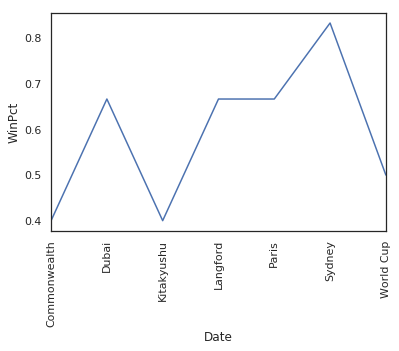

In [4]:
grouped1 = games.groupby('Tournament')
series = grouped1['Outcome'].mean()
series.plot()
plt.xlabel('Date')
plt.ylabel('WinPct')
plt.xticks(rotation=90)
plt.show()

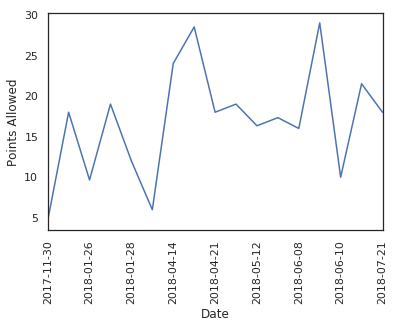

In [5]:
grouped1 = games.groupby('Date')
series = grouped1['TeamPointsAllowed'].mean()
series.plot()
plt.xlabel('Date')
plt.ylabel('Points Allowed')
plt.xticks(rotation=90)
plt.show()

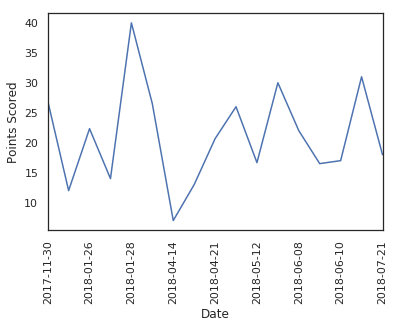

In [6]:
grouped1 = games.groupby('Date')
series = grouped1['TeamPoints'].mean()
series.plot()
plt.xlabel('Date')
plt.ylabel('Points Scored')
plt.xticks(rotation=90)
plt.show()

**Replacing dates with increasing integers to better compare things happening on the certain days**

In [7]:
for i, row in rpe.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    rpe.at[i,'Date'] = a1

for i, row in games.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    games.at[i,'Date'] = a1

for i, row in wellness.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    wellness.at[i,'Date'] = a1
    
    #replacing percent strings with float percents
    wellness.at[i,'TrainingReadiness'] = float(row['TrainingReadiness'].strip('%'))

In [8]:
games.head()

,GameID,Date,Tournament,TournamentGame,Team,Opponent,Outcome,TeamPoints,TeamPointsAllowed
0,1,20171130,Dubai,1,Canada,Spain,1,19,0
1,2,20171130,Dubai,2,Canada,Ireland,1,31,0
2,3,20171130,Dubai,3,Canada,Fiji,1,31,14
3,4,20171201,Dubai,4,Canada,France,1,24,19
4,5,20171201,Dubai,5,Canada,Australia,0,7,25


In [9]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely


In [10]:
wellness.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,20180721,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0
1,20180721,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0
2,20180721,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100
3,20180721,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95
4,20180721,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100


**Standardizing self reported player answers by calculating the z score for each players answers**

In [11]:
def standardize_col(df, col):
    
    player_grouped = df.groupby('PlayerID')
    
    for p_id in list(range(1,18)):
        mean = player_grouped.get_group(p_id)[col].mean()
        std = player_grouped.get_group(p_id)[col].std()
        for i, row in df.iterrows():
            if row['PlayerID'] == p_id:
                df.at[i, col+'_Z'] = (row[col]-mean)/std
            else:
                pass

wellness_cols = ['Fatigue', 'Soreness', 'Irritability', 'Desire', 'SleepQuality', 'TrainingReadiness']

for col in wellness_cols:
    standardize_col(wellness, col)

standardize_col(rpe,'RPE')

In [12]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403


In [13]:
wellness.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,...,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness,Fatigue_Z,Soreness_Z,Irritability_Z,Desire_Z,SleepQuality_Z,TrainingReadiness_Z
0,20180721,1,3,3,2,3,23:00:00,07:00:00,8.00,2,...,Yes,No,NaN,0,0.318219,-0.304322,-0.987002,-0.415362,-1.551148,-0.562599
1,20180721,2,4,3,4,4,23:00:00,07:00:00,8.00,4,...,NaN,Yes,1.010,0,0.207884,-0.230312,-0.186841,-0.121453,-0.100390,-0.410237
2,20180721,3,3,3,5,4,22:30:00,06:30:00,8.00,4,...,NaN,Yes,1.016,100,-0.578512,-0.279482,0.143069,2.144929,0.255789,0.558418
3,20180721,4,2,3,5,4,00:30:00,07:00:00,6.50,1,...,Yes,Yes,1.025,95,-1.591780,-0.605094,0.463336,1.575278,-1.447874,0.621488
4,20180721,5,5,3,4,4,23:45:00,07:00:00,7.25,4,...,Yes,Yes,1.022,100,1.808898,-0.983282,0.054038,-0.403411,0.286967,0.891845


This exploration was using multiple regression to see if the players self reported wellness scores on game days could be used to predict whether they would win, how many points they would score, and how many points they gave up. To do this we calculated the mean wellness scores on game day dates and added them to the game dataframe in order to use the statsmodels module to run multiple regression. The cell below adds these values to the game dataframe.

In [14]:
date_grouped = wellness.groupby('Date')
mean_fat = date_grouped['Fatigue_Z'].mean()
mean_sore = date_grouped['Soreness_Z'].mean()
mean_des = date_grouped['Desire_Z'].mean()
mean_irr = date_grouped['Irritability_Z'].mean()
mean_sleepq = date_grouped['SleepQuality_Z'].mean()
mean_sleept = date_grouped['SleepHours'].mean()
mean_readiness = date_grouped['TrainingReadiness_Z'].mean()

for i, row in games.iterrows():
    games.at[i, 'Fat'] = mean_fat[row['Date']]
    games.at[i, 'Sore'] = mean_sore[row['Date']]
    games.at[i, 'Des'] = mean_des[row['Date']]
    games.at[i, 'Irr'] = mean_irr[row['Date']]
    games.at[i, 'SleepQ'] = mean_sleepq[row['Date']]
    games.at[i, 'SleepT'] = mean_sleept[row['Date']]
    games.at[i, 'Readiness'] = mean_readiness[row['Date']]
    
games.head()

,GameID,Date,Tournament,TournamentGame,Team,Opponent,Outcome,TeamPoints,TeamPointsAllowed,Fat,Sore,Des,Irr,SleepQ,SleepT,Readiness
0,1,20171130,Dubai,1,Canada,Spain,1,19,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
1,2,20171130,Dubai,2,Canada,Ireland,1,31,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
2,3,20171130,Dubai,3,Canada,Fiji,1,31,14,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
3,4,20171201,Dubai,4,Canada,France,1,24,19,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882
4,5,20171201,Dubai,5,Canada,Australia,0,7,25,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882


We started by making a preliminary correlation matrix to see if anything jumped out as a good predictor of game outcome or point totals.

In [15]:
columns = ['Outcome', 'TeamPoints', 'TeamPointsAllowed', 'Fat', 'Sore', 'Des', 'Irr', 'SleepQ', 'SleepT',
           'Sum_Z']
games['Sum_Z'] = games['Fat']+games['Sore']+games['Des']+games['Irr']+games['SleepQ']+games['Readiness']
games[columns].corr()

,Outcome,TeamPoints,TeamPointsAllowed,Fat,Sore,Des,Irr,SleepQ,SleepT,Sum_Z
Outcome,1.000000,0.740171,-0.751528,0.188176,0.216107,0.153654,0.042370,0.081989,0.125938,0.177702
TeamPoints,0.740171,1.000000,-0.483780,0.185534,0.220732,0.120468,0.100627,0.006960,0.182159,0.147918
TeamPointsAllowed,-0.751528,-0.483780,1.000000,-0.308816,-0.304649,-0.216315,-0.129036,-0.187217,-0.078184,-0.287469
Fat,0.188176,0.185534,-0.308816,1.000000,0.884424,0.535827,0.595916,0.854533,0.554684,0.909093
Sore,0.216107,0.220732,-0.304649,0.884424,1.000000,0.594816,0.446359,0.734270,0.629811,0.911977
Des,0.153654,0.120468,-0.216315,0.535827,0.594816,1.000000,0.752196,0.695644,-0.025541,0.800593
Irr,0.042370,0.100627,-0.129036,0.595916,0.446359,0.752196,1.000000,0.817361,0.137786,0.733905
SleepQ,0.081989,0.006960,-0.187217,0.854533,0.734270,0.695644,0.817361,1.000000,0.387897,0.915718
SleepT,0.125938,0.182159,-0.078184,0.554684,0.629811,-0.025541,0.137786,0.387897,1.000000,0.458045
Sum_Z,0.177702,0.147918,-0.287469,0.909093,0.911977,0.800593,0.733905,0.915718,0.458045,1.000000


These wellness scored don't seem to be a particularly good predictor of winning or losing, as there is a pretty low r^2 value.

In [16]:
import statsmodels.formula.api as smf

outcome_model = smf.logit('Outcome ~ Fat + Sore + Des + Irr + SleepQ + SleepT + Readiness', data=games)
outcome_res = outcome_model.fit()
outcome_res.summary()

Optimization terminated successfully.
         Current function value: 0.616572
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                   38
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            7
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                 0.08087
Time:                        03:51:49   Log-Likelihood:                -23.430
converged:                       True   LL-Null:                       -25.491
                                        LLR p-value:                    0.7655
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4819     13.894     -0.898      0.369     -39.713      14.749
Fat            2.3093      2.565      0.900      0.368      -2.718       7.337
Sore          -1.0263      1.813     -0.566      0.571      -4.581       2.528
Des            3.6516      3.255      1.122      0.262      -2.728      10.032
Irr           -3.1695      5.056     -0.627      0.531     -13.079       6.740
SleepQ        -2.1108      3.189     -0.662      0.508      -8.360       4.139
SleepT         1.1104      1.432      0.776      0.438      -1.696       3.916
Readiness     -1.3527      2.819     -0.480      0.631      -6.877       4.171
==============================================================================
"""

This is the best multiple regression model we found so far, using the wellness scores to try to predict the points that the team scored in a game. The r^2 value is still pretty low, but its at least better.

In [17]:
offense_model = smf.ols('TeamPoints ~ Fat + Sore + Des + Irr + SleepQ + SleepT + Readiness', data=games)
offense_res = offense_model.fit()
offense_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TeamPoints   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     1.597
Date:                Mon, 08 Apr 2019   Prob (F-statistic):              0.175
Time:                        03:51:49   Log-Likelihood:                -136.94
No. Observations:                  38   AIC:                             289.9
Df Residuals:                      30   BIC:                             303.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -48.6181     64.772     -0.751      0.459    -180.900      83.664
Fat           10.9513     11.650      0.940      0.355     -12.841      34.743
Sore          -0.3869      8.225     -0.047      0.963     -17.185      16.412
Des           12.6822     14.253      0.890      0.381     -16.427      41.791
Irr           16.6055     21.719      0.765      0.450     -27.750      60.961
SleepQ       -31.1177     14.480     -2.149      0.040     -60.691      -1.545
SleepT         5.8181      6.759      0.861      0.396      -7.985      19.621
Readiness    -13.3669     12.958     -1.032      0.311     -39.831      13.097
==============================================================================
Omnibus:                        1.149   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                0.922
Skew:                           0.074   Prob(JB):                        0.631
Kurtosis:                       2.252   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at points allowed, still pretty low predictive quality.

In [18]:
defense_model = smf.ols('TeamPointsAllowed ~ Fat + Sore + Des + Irr + SleepQ + SleepT + Readiness', data=games)
defense_res = defense_model.fit()
defense_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      TeamPointsAllowed   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.8461
Date:                Mon, 08 Apr 2019   Prob (F-statistic):              0.559
Time:                        03:51:49   Log-Likelihood:                -133.22
No. Observations:                  38   AIC:                             282.4
Df Residuals:                      30   BIC:                             295.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.7724     58.733     -0.217      0.829    -132.722     107.177
Fat          -11.9329     10.564     -1.130      0.268     -33.507       9.641
Sore          -3.1246      7.459     -0.419      0.678     -18.357      12.108
Des            2.2362     12.924      0.173      0.864     -24.159      28.631
Irr           -7.0840     19.694     -0.360      0.722     -47.304      33.136
SleepQ        14.5318     13.130      1.107      0.277     -12.284      41.348
SleepT         4.4085      6.129      0.719      0.478      -8.108      16.925
Readiness     -7.3942     11.750     -0.629      0.534     -31.391      16.603
==============================================================================
Omnibus:                        1.947   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.243
Skew:                          -0.130   Prob(JB):                        0.537
Kurtosis:                       2.153   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The next exploration we did was using the RPE (rate of percieved exertion values reported for training sessions) values of each day to predict wellness scores for the next day. In order to do this our first step was to add the wellness z scores of the next day to the rpe dataframe.**

In [19]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403


In [20]:
wellness.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,...,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness,Fatigue_Z,Soreness_Z,Irritability_Z,Desire_Z,SleepQuality_Z,TrainingReadiness_Z
0,20180721,1,3,3,2,3,23:00:00,07:00:00,8.00,2,...,Yes,No,NaN,0,0.318219,-0.304322,-0.987002,-0.415362,-1.551148,-0.562599
1,20180721,2,4,3,4,4,23:00:00,07:00:00,8.00,4,...,NaN,Yes,1.010,0,0.207884,-0.230312,-0.186841,-0.121453,-0.100390,-0.410237
2,20180721,3,3,3,5,4,22:30:00,06:30:00,8.00,4,...,NaN,Yes,1.016,100,-0.578512,-0.279482,0.143069,2.144929,0.255789,0.558418
3,20180721,4,2,3,5,4,00:30:00,07:00:00,6.50,1,...,Yes,Yes,1.025,95,-1.591780,-0.605094,0.463336,1.575278,-1.447874,0.621488
4,20180721,5,5,3,4,4,23:45:00,07:00:00,7.25,4,...,Yes,Yes,1.022,100,1.808898,-0.983282,0.054038,-0.403411,0.286967,0.891845


putting wellness avg data in the rpe dataframe, where the wellness data is from the day after the rpe data

These next 2 cells take the rpe dataframe and add the wellness z scores from the following day to it so that we can run statsmodels regression on it.

In [21]:
def next_day(rpe_df, wellness_df, rpe_row):
    
    rpe_date = rpe_row['Date']
    next_date = wellness_df[wellness_df['Date'] > rpe_date].min()
    
    return next_date['Date']

In [22]:
well_dates = wellness.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']

for i, row in rpe.iterrows():
    if row['Date'] < rpe['Date'].max():
        well_date = next_day(rpe, wellness, row)
        well_rows = well_dates.get_group(well_date)
        for i2, row2 in well_rows.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    rpe.at[i, col] = row2[col]

rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472,NaN,NaN,NaN,NaN,NaN
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176,NaN,NaN,NaN,NaN,NaN
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789,NaN,NaN,NaN,NaN,NaN
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374,1.671003,0.426559,2.815371,0.652563,-0.230249
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403,1.671003,0.426559,2.815371,0.652563,-0.230249


In [23]:
rpe.head(20)

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472,NaN,NaN,NaN,NaN,NaN
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176,NaN,NaN,NaN,NaN,NaN
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789,NaN,NaN,NaN,NaN,NaN
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374,1.671003,0.426559,2.815371,0.652563,-0.230249
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403,1.671003,0.426559,2.815371,0.652563,-0.230249
5,20180720,11,Yes,Mobility/Recovery,15.0,2.0,30.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,-1.139683,1.671003,0.426559,2.815371,0.652563,-0.230249
6,20180720,13,Yes,Game,27.0,6.0,162.0,306.0,259.4,287.32,0.90,NaN,NaN,Not at all,0.809369,0.802189,0.110634,2.273088,0.000000,0.204348
7,20180720,13,Yes,Game,24.0,6.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,0.809369,0.802189,0.110634,2.273088,0.000000,0.204348
8,20180720,13,Yes,Mobility/Recovery,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,-1.253472,0.802189,0.110634,2.273088,0.000000,0.204348
9,20180719,1,Yes,Skills,60.0,3.0,180.0,180.0,87.9,140.54,0.63,NaN,NaN,NaN,-0.254554,0.318219,0.700575,0.450886,0.066465,-1.551148


Initial correlation matrix. Soreness is the most correlated with RPE, but still not very high.

In [24]:
columns = ['RPE_Z', 'Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']
rpe[columns].corr()

,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
RPE_Z,1.000000,-0.088729,-0.214393,-0.059556,-0.015304,-0.008024
Fatigue_Z,-0.088729,1.000000,0.442297,0.446630,0.300802,0.383698
Soreness_Z,-0.214393,0.442297,1.000000,0.348918,0.179070,0.152310
Desire_Z,-0.059556,0.446630,0.348918,1.000000,0.360820,0.218769
Irritability_Z,-0.015304,0.300802,0.179070,0.360820,1.000000,0.261351
SleepQuality_Z,-0.008024,0.383698,0.152310,0.218769,0.261351,1.000000


**These next cells plot the wellness scores as dependent variables against the (hopefully predictive) RPEs of the previous. Unfortunately nothing seems to be even remotely predictive. We are not done with this path though, as we are exploring ways to combine rpe values from the same day into a single number, like the wellness scores, in a way that will allow us to predict the wellness scores better. As of right now we think part of our issue is that we can have multiple rpe scores for the same day (for multiple games and training sessions in the same day) but all of those different scores have the same wellness z scores associated with them on each day. Hopefully we will be able to find a way to combine RPE in a way that makes sense and allow us to make better wellness predictions.**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fatigue_Z   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     56.82
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           5.35e-14
Time:                        03:54:24   Log-Likelihood:                -10176.
No. Observations:                7163   AIC:                         2.036e+04
Df Residuals:                    7161   BIC:                         2.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0917      0.012     -7.743      0.000      -0.115      -0.068
RPE_Z         -0.0893      0.012     -7.538      0.000      -0.113      -0.066
==============================================================================
Omnibus:                      128.376   Durbin-Watson:                   0.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.074
Skew:                          -0.336   Prob(JB):                     4.67e-30
Kurtosis:                       3.015   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

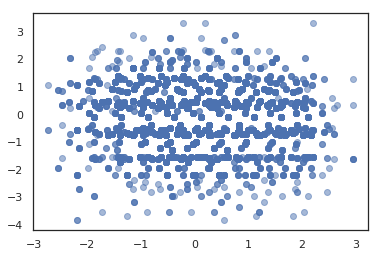

In [25]:
model = smf.ols('Fatigue_Z ~ RPE_Z', data=rpe)
res = model.fit()
plt.plot(rpe.RPE_Z, rpe.Fatigue_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day fatigue', xlabel='RPE Z score',
#          ylabel='Fatigue Z score')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Soreness_Z   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     345.0
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           2.97e-75
Time:                        03:54:24   Log-Likelihood:                -9703.3
No. Observations:                7163   AIC:                         1.941e+04
Df Residuals:                    7161   BIC:                         1.942e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3283      0.011    -29.623      0.000      -0.350      -0.307
RPE_Z         -0.2060      0.011    -18.574      0.000      -0.228      -0.184
==============================================================================
Omnibus:                       28.779   Durbin-Watson:                   0.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.074
Skew:                          -0.156   Prob(JB):                     4.86e-07
Kurtosis:                       2.993   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

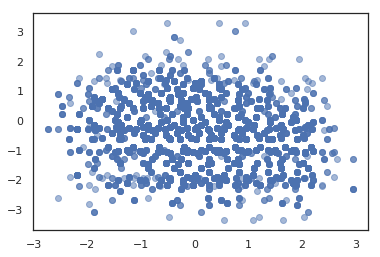

In [26]:
model = smf.ols('Soreness_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Soreness_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day soreness', xlabel='RPE Z score',
#          ylabel='Soreness Z score')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Irritability_Z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.678
Date:                Mon, 08 Apr 2019   Prob (F-statistic):              0.195
Time:                        03:54:24   Log-Likelihood:                -9702.5
No. Observations:                7163   AIC:                         1.941e+04
Df Residuals:                    7161   BIC:                         1.942e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0318      0.011     -2.867      0.004      -0.053      -0.010
RPE_Z         -0.0144      0.011     -1.295      0.195      -0.036       0.007
==============================================================================
Omnibus:                     2504.715   Durbin-Watson:                   0.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141201.143
Skew:                          -0.874   Prob(JB):                         0.00
Kurtosis:                      24.681   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

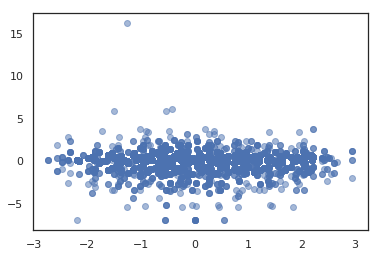

In [27]:
model = smf.ols('Irritability_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Irritability_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day irritability', xlabel='RPE Z score',
#          ylabel='Irritability Z score')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Desire_Z   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     25.49
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           4.56e-07
Time:                        03:54:24   Log-Likelihood:                -10021.
No. Observations:                7163   AIC:                         2.005e+04
Df Residuals:                    7161   BIC:                         2.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0069      0.012     -0.600      0.549      -0.030       0.016
RPE_Z         -0.0585      0.012     -5.049      0.000      -0.081      -0.036
==============================================================================
Omnibus:                      979.914   Durbin-Watson:                   0.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13420.956
Skew:                           0.019   Prob(JB):                         0.00
Kurtosis:                       9.706   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

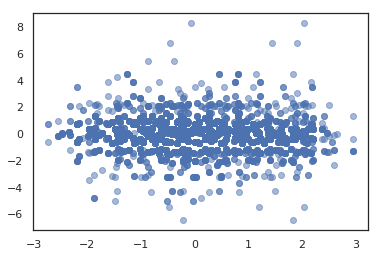

In [28]:
model = smf.ols('Desire_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Desire_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day desire', xlabel='RPE Z score',
#          ylabel='Desire Z score')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SleepQuality_Z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4611
Date:                Mon, 08 Apr 2019   Prob (F-statistic):              0.497
Time:                        03:54:24   Log-Likelihood:                -9838.3
No. Observations:                7163   AIC:                         1.968e+04
Df Residuals:                    7161   BIC:                         1.969e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.011      0.380      0.704      -0.018       0.026
RPE_Z         -0.0077      0.011     -0.679      0.497      -0.030       0.014
==============================================================================
Omnibus:                      753.362   Durbin-Watson:                   0.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1701.190
Skew:                          -0.643   Prob(JB):                         0.00
Kurtosis:                       5.012   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

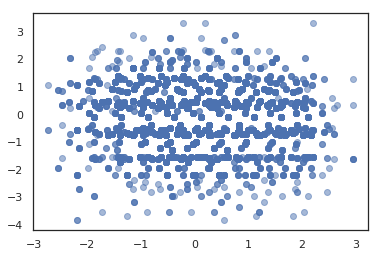

In [29]:
model = smf.ols('SleepQuality_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Fatigue_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day sleep quality', xlabel='RPE Z score',
#          ylabel='Sleep Quality Z score')
res = model.fit()
res.summary()

In [30]:
gps.head()

,GameID,Half,PlayerID,FrameID,Time,GameClock,Speed,AccelImpulse,AccelLoad,AccelX,AccelY,AccelZ,Longitude,Latitude
0,1,1,2,1,00:22:01,00:00:00,0.658334,0.611112,0.005330,0.13250,0.69875,0.56500,55.466666,24.994873
1,1,1,2,2,00:22:01,00:00:00,0.594445,0.638889,0.006568,0.11125,0.92000,0.70625,55.466666,24.994874
2,1,1,2,3,00:22:01,00:00:00,0.363889,2.305557,0.003114,0.01375,0.77000,0.67750,55.466667,24.994874
3,1,1,2,4,00:22:01,00:00:00,0.444445,0.805556,0.002602,0.00625,0.88625,0.59500,55.466667,24.994874
4,1,1,2,5,00:22:01,00:00:00,0.400000,0.444445,0.003813,-0.01750,0.85750,0.57375,55.466668,24.994874


We combined some data from the games dataframe with the gps so that we would know the dates on which certain games happened.

In [31]:
game2 = games[['GameID', 'Date']].copy()
gps = pd.merge(game2,gps, on=['GameID'])

We tried to look into how the number of tackles/hits a player was involved in affected their health. For now, we are using a rather simple model for a hit, as we are assuming any absolute change in velocity, or acceleration impulse, of more than 5.8 m/s^2 is a hit/tackle/encounter with another player. It is certainly possible that some of the hits are not from tackles, as they seem to occur in areas where the player does not change directions much at the spot where the acceleration happens. Additionally, it is possible to take a hit and continue moving. We are looking into other ways of determining a hit.

The plots of latitude and longitude below are not particularly useful, but they do provide a sense of where the accelerations are happening.

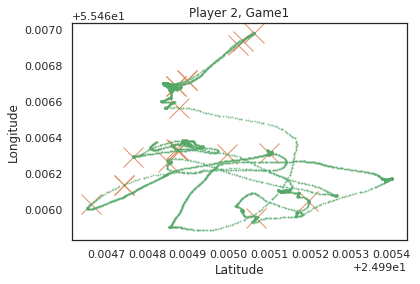

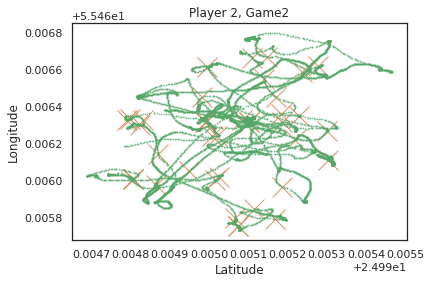

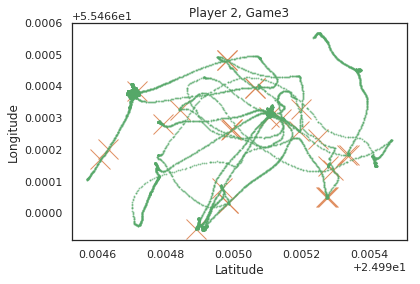

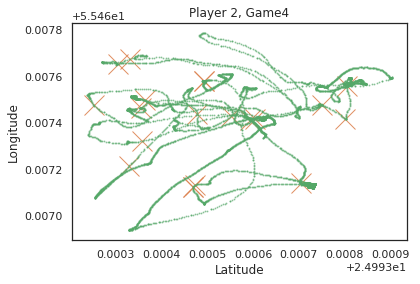

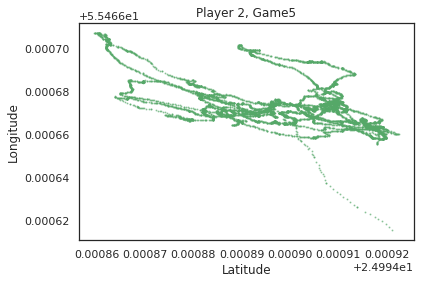

In [32]:
for num in np.arange(2,3):
    for gamenum in np.arange(1,6):
        p1 = gps[gps.PlayerID == num]
        p1 = p1[p1.GameID == gamenum]
        px = p1[p1.AccelImpulse > 5.8]
        l1 = px['Latitude']
        l2 = px['Longitude']
        plt.plot(l1,l2,'x',color='C1',alpha=0.9,markersize=20)
        lat = p1['Latitude']
        lon = p1['Longitude']
        plt.plot(lat,lon,'o',color='C2',alpha=0.5,markersize=1)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title('Player '+str(num)+', Game'+str(gamenum))
        plt.show()

We create a new dataframe containing the information on the number of significant accelerations a player experienced on a given day.

In [33]:
hits = pd.DataFrame()
# df['GameID'] = gps['GameID']    
hits['PlayerID'] = gps['PlayerID']
hits['Date'] = gps['Date']

# df = df.drop_duplicates(subset=['GameID', 'PlayerID', 'Date'], keep='first')
hits = hits.drop_duplicates(subset=['PlayerID', 'Date'], keep='first')

hits['hits'] = 0

for i, row in hits.iterrows():
    p1 = gps[gps.PlayerID == row.PlayerID]
    p1 = p1[p1.Date == row.Date]
    hit = len(p1[p1.AccelImpulse > 5.8])
    hits.at[i, 'hits'] = hit

In [34]:
hits.head()

,PlayerID,Date,hits
0,2,20171130,87
5257,3,20171130,50
10514,4,20171130,77
15771,6,20171130,48
21028,7,20171130,50


We can combine this with the wellness data as well.

In [35]:
x = pd.merge(hits, wellness, on=['PlayerID', 'Date'])

In [36]:
columns = ['hits', 'Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']
x[columns].corr()

,hits,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
hits,1.000000,0.232414,0.280128,0.161659,0.084905,-0.024184
Fatigue_Z,0.232414,1.000000,0.625400,0.414044,0.259299,0.451299
Soreness_Z,0.280128,0.625400,1.000000,0.418700,0.199949,0.367047
Desire_Z,0.161659,0.414044,0.418700,1.000000,0.230564,0.204641
Irritability_Z,0.084905,0.259299,0.199949,0.230564,1.000000,0.233703
SleepQuality_Z,-0.024184,0.451299,0.367047,0.204641,0.233703,1.000000


In [37]:
model = smf.ols('Soreness_Z ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Soreness_Z   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     16.78
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           6.14e-05
Time:                        03:54:33   Log-Likelihood:                -308.09
No. Observations:                 199   AIC:                             620.2
Df Residuals:                     197   BIC:                             626.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5357      0.174     -3.075      0.002      -0.879      -0.192
hits           0.0146      0.004      4.096      0.000       0.008       0.022
==============================================================================
Omnibus:                        1.966   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.942
Skew:                          -0.238   Prob(JB):                        0.379
Kurtosis:                       2.914   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Next we investigated how the number of 'hits', or large accelerations, affected the fatigue, soreness, etc. of the player on the next day.

In [38]:
well_dates = wellness.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']

for i, row in hits.iterrows():
    if row['Date'] < hits['Date'].max():
        well_date = next_day(hits, wellness, row)
        well_rows = well_dates.get_group(well_date)
        for i2, row2 in well_rows.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    hits.at[i, col] = row2[col]

In [39]:
columns = ['hits', 'Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']
hits[columns].corr()

,hits,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
hits,1.000000,0.049515,-0.170430,0.133113,0.115983,-0.148633
Fatigue_Z,0.049515,1.000000,0.605855,0.528985,0.267495,0.490682
Soreness_Z,-0.170430,0.605855,1.000000,0.534527,0.153955,0.374155
Desire_Z,0.133113,0.528985,0.534527,1.000000,0.457712,0.335665
Irritability_Z,0.115983,0.267495,0.153955,0.457712,1.000000,0.224141
SleepQuality_Z,-0.148633,0.490682,0.374155,0.335665,0.224141,1.000000


At this point, we began to feel like we were missing something and getting lost in the numbers, so we decided to visualize some of the data we were looking at further.

/home/dconnolly/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


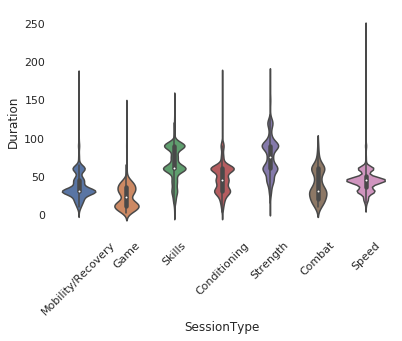

In [40]:
data = rpe.dropna(subset=['Duration', 'SessionType'])
sns.violinplot(x='SessionType', y='Duration', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('SessionType')
plt.ylabel('Duration');

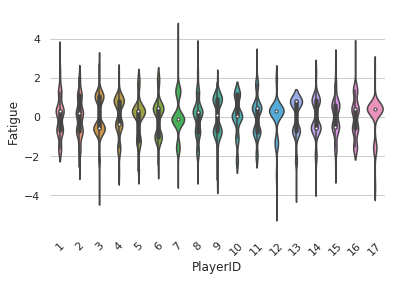

In [41]:
data = wellness.dropna(subset=['PlayerID', 'Fatigue_Z'])
sns.violinplot(x='PlayerID', y='Fatigue_Z', data=data, whis=100)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('PlayerID')
plt.ylabel('Fatigue');

The plot below suggests that women on the team that were menstruating experienced a higher number of 'hits' than the other women on the team. We'll need to change the axes labels once we come to a final decision on what to define as a hit and/or what to call a high Acceleration Impulse. Note: Right now, the axes labels for potential hits/tackles/AccelImpulses are somewhat inconsistent. We'll fix that later.

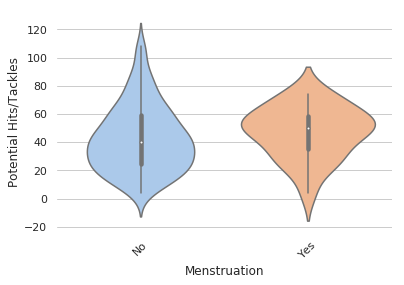

In [42]:
data = x.dropna(subset=['Menstruation', 'hits'])
sns.violinplot(x='Menstruation', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Menstruation')
plt.ylabel('Potential Hits/Tackles');

As long as the women are getting okay nutrtion, they seem to be involved in the same amount of potential hits/tackles as those getting excellent nutrition.

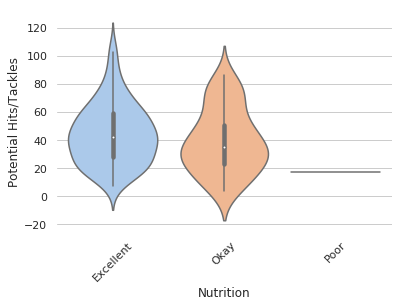

In [43]:
data = x.dropna(subset=['Nutrition', 'hits'])
sns.violinplot(x='Nutrition', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Nutrition')
plt.ylabel('Potential Hits/Tackles');

The plot below shows that those who felt slightly off were slightly more likely to experience large accelerations in games than the other women on the team.

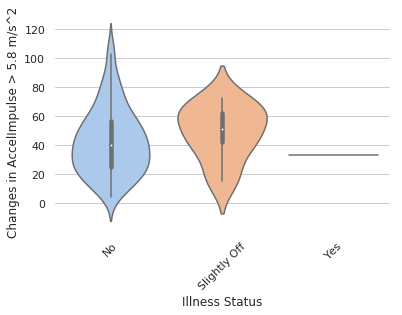

In [44]:
data = x.dropna(subset=['Illness', 'hits'])
sns.violinplot(x='Illness', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Illness Status')
plt.ylabel('Changes in AccelImpulse > 5.8 m/s^2');

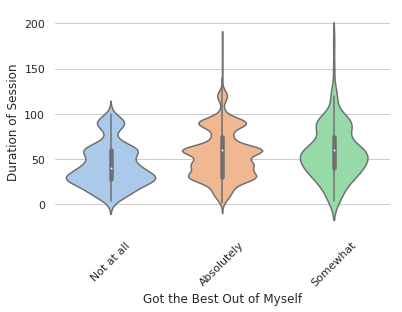

In [45]:
data = rpe.dropna(subset=['BestOutOfMyself', 'Duration'])
sns.violinplot(x='BestOutOfMyself', y='Duration', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Got the Best Out of Myself')
plt.ylabel('Duration of Session');

Below, we can see that the athletes tend to rate their perceived effort slightly above average in the longest sessions. It appears to be a concave-down parabola, so we will try to fit a parabola to it.

Text(0.5, 1.0, 'Duration of Session vs. RPE')

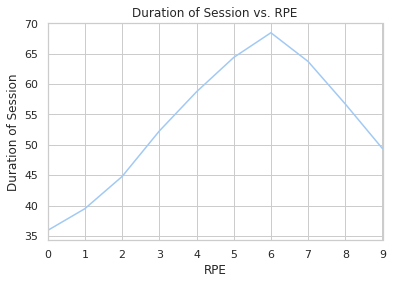

In [46]:
grouped = rpe.groupby('RPE')
duration_by_rpe = grouped['Duration'].mean()
duration_by_rpe.plot()
plt.xlabel('RPE')
plt.ylabel('Duration of Session')
plt.title('Duration of Session vs. RPE')

In [47]:
xrpe = rpe
xrpe['rpe2'] = xrpe['RPE']**2
model = smf.ols('Duration ~ RPE + rpe2', data=xrpe)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Duration   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     467.3
Date:                Mon, 08 Apr 2019   Prob (F-statistic):          3.60e-192
Time:                        03:54:37   Log-Likelihood:                -35420.
No. Observations:                7621   AIC:                         7.085e+04
Df Residuals:                    7618   BIC:                         7.087e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.4659      0.884     34.459      0.000      28.733      32.199
RPE           10.8960      0.421     25.860      0.000      10.070      11.722
rpe2          -0.9092      0.047    -19.501      0.000      -1.001      -0.818
==============================================================================
Omnibus:                      488.591   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.628
Skew:                           0.559   Prob(JB):                    1.77e-150
Kurtosis:                       3.959   Cond. No.                         100.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
df = pd.DataFrame()
df['RPE'] = np.linspace(0,9)
df['rpe2'] = df['RPE']**2

The parabola doesn't fit the data perfectly, but considering we are plotting mean durations and not the durations of each individual session, it is likely that our parabola fits the data better than we think. It does seem to model the data fairly well.

Text(0.5, 1.0, 'Duration of Session vs. RPE')

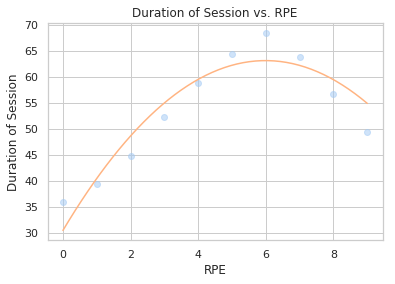

In [49]:
plt.plot(duration_by_rpe, 'o', alpha=0.5)
pred = res.predict(df)
plt.plot(df['RPE'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('RPE')
plt.ylabel('Duration of Session')
plt.title('Duration of Session vs. RPE')

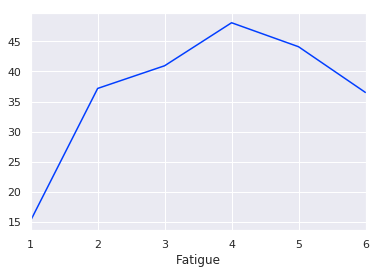

In [51]:
grouped = x.groupby('Fatigue')
hits_by_fat = grouped['hits'].mean()
hits_by_fat.plot()

In [52]:
xwell = x
xwell['fat2'] = xwell['Fatigue']**2
model = smf.ols('hits ~ Fatigue + fat2', data=xwell)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hits   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5.644
Date:                Mon, 08 Apr 2019   Prob (F-statistic):            0.00414
Time:                        03:55:05   Log-Likelihood:                -898.30
No. Observations:                 199   AIC:                             1803.
Df Residuals:                     196   BIC:                             1812.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0237     14.865     -0.069      0.945     -30.340      28.293
Fatigue       22.8177      8.808      2.590      0.010       5.446      40.189
fat2          -2.7136      1.274     -2.129      0.034      -5.227      -0.200
==============================================================================
Omnibus:                        8.184   Durbin-Watson:                   1.215
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.592
Skew:                           0.503   Prob(JB):                       0.0136
Kurtosis:                       2.839   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that the potential hits also have a parabolic relationship with the fatigue ratings.

Text(0.5, 1.0, 'Potential Hits vs. Fatigue Rating')

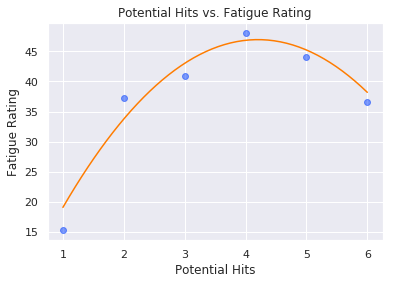

In [53]:
df = pd.DataFrame()
df['Fatigue'] = np.linspace(1,6)
df['fat2'] = df['Fatigue']**2
plt.plot(hits_by_fat, 'o', alpha=0.5)
pred = res.predict(df)
plt.plot(df['Fatigue'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Fatigue Rating')
plt.title('Potential Hits vs. Fatigue Rating')

In [54]:
x.head()

,PlayerID,Date,hits,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,...,USGMeasurement,USG,TrainingReadiness,Fatigue_Z,Soreness_Z,Irritability_Z,Desire_Z,SleepQuality_Z,TrainingReadiness_Z,fat2
0,2,20171130,87,4,4,5,4,21:15:00,06:00:00,8.75,...,Yes,1.019,0,0.207884,0.600282,-0.186841,0.991322,0.709900,-0.410237,16
1,3,20171130,50,5,4,6,4,21:30:00,05:30:00,8.00,...,Yes,1.009,100,2.695019,1.264321,0.143069,3.532354,0.255789,0.558418,25
2,4,20171130,77,3,6,6,5,01:00:00,07:15:00,6.25,...,Yes,1.021,100,-0.374305,2.733729,1.866970,3.054795,-1.447874,0.732687,9
3,6,20171130,48,4,4,4,4,22:00:00,07:15:00,9.25,...,Yes,1.009,90,0.442752,0.784782,0.145116,0.126636,0.022630,0.593317,16
4,7,20171130,50,5,4,6,4,21:00:00,06:00:00,9.00,...,Yes,1.009,95,2.761663,1.345970,0.572573,3.761415,0.187121,0.110933,25


Below, USG means urine specific gravity. Above 1.025 indicates mild dehydration according to the codebook.

Text(0.5, 1.0, 'USG vs. potential hits')

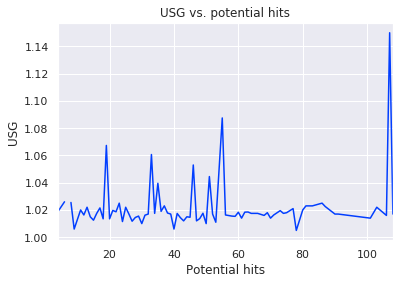

In [55]:
grouped = x.groupby('hits')
series = grouped['USG'].mean()
series.plot()
plt.xlabel('Potential hits')
plt.ylabel('USG')
plt.title('USG vs. potential hits')

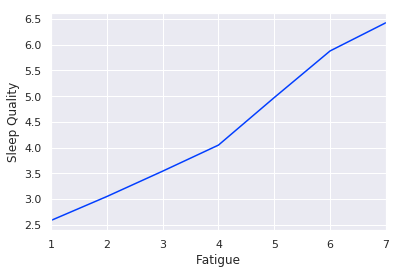

In [56]:
grouped = wellness.groupby('Fatigue')
fatigue_by_sleepqual = grouped['SleepQuality'].mean()
fatigue_by_sleepqual.plot()
plt.xlabel('Fatigue')
plt.ylabel('Sleep Quality')
plt.show()

In [57]:
formula = 'SleepQuality ~ Fatigue'
results = smf.ols(formula,data=wellness).fit()
results.params

Intercept    1.746744
Fatigue      0.603220
dtype: float64

It's not particularly surprising that fatigue and sleep quality have a fairly linear relationship.

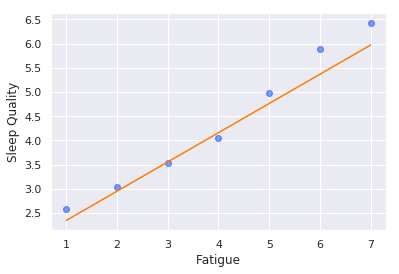

In [58]:
df = pd.DataFrame()
df['Fatigue'] = np.linspace(1,7)
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)
pred = results.predict(df)
plt.plot(df['Fatigue'], pred)
plt.xlabel('Fatigue')
plt.ylabel('Sleep Quality')
plt.show()

I would like to figure out how to smooth the plot below out. I ran into multiple issues when trying to convert the game clock from a string and then to unix time (or anytime that isn't base 60 as this messes with plots).

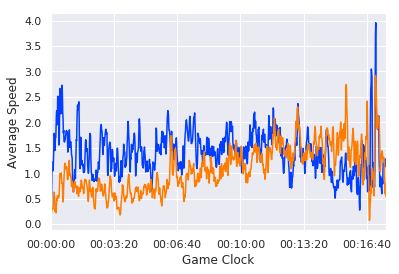

In [59]:
for playerid in np.arange(1,3):
    gpsx = gps[gps.PlayerID == playerid]
    grouped = gpsx.groupby('GameClock')
    series = grouped['Speed'].mean()
    series.plot()
#     ax = sns.regplot(gpsx.GameClock, gpsx.GameClock)
plt.xlabel('Game Clock')
plt.ylabel('Average Speed')
plt.show()